# QUIDDIT 
## Quantification of Infrared-active Defects in Diamond and Inferred Temperatures

## 1) Baseline Correction and Normalisation
The purpose of this section is to read measured spectra from CSV files in a directory, normalise each spectrum to a thickness of 1 cm based on a normalised type IIa spectrum and to subtract the intrinsic diamond absorption. Each spectrum is then saved as a new CSV file in a different folder.

### 1.1)  Imports and Data
Let's start by importing a few important functions and reading the measured and standard type IIa spectra.

In [4]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
#the following imports some important QUIDDIT functions
import QUIDDIT_utility as ut

Populating the interactive namespace from numpy and matplotlib


In [5]:
#this is the normalised type IIa spectrum
IIa_spec = np.loadtxt('C:\FTIR/typeIIa.csv', delimiter = ',')

#this is the measured spectrum that will be read
#measured_spec = np.loadtxt('C:\FTIR/aafakedata/LS Arg 81 HQ linescan 40 300025.CSV', delimiter=',')
measured_spec = np.loadtxt('C:\FTIR/LS Arg 09 HQ linescan/LS Arg 09 HQ linescan 30 250009.CSV', delimiter=',')
prelim_spec = ut.spectrum_slice(measured_spec, 675, 4000)
#the spectrum_slice function returns a slice of a spectrum defined by a wavenumber range; in this case 675-4000 cm-1

Now let's see what they look like!


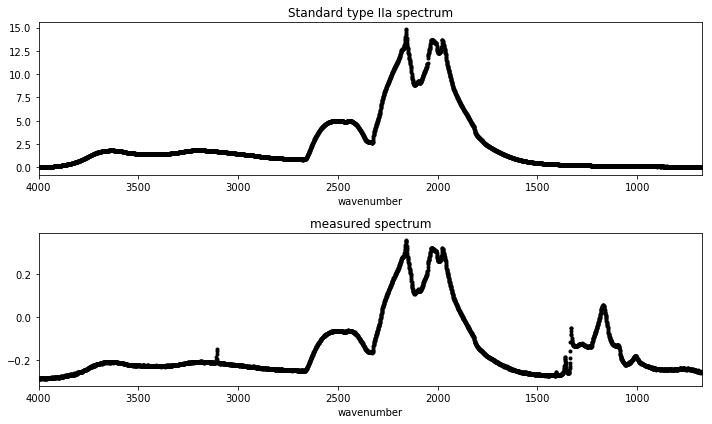

In [6]:
plt.subplot(2,1,1)
plt.plot(IIa_spec[:,0], IIa_spec[:,1], 'k.')
plt.xlim(675,4000)
plt.xlabel('wavenumber')
plt.title('Standard type IIa spectrum')
plt.gca().invert_xaxis()

plt.subplot(2,1,2)
plt.plot(prelim_spec[:,0], prelim_spec[:,1], 'k.')
plt.xlim(675,4000)
plt.title('measured spectrum')
plt.xlabel('wavenumber')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

Note the difference in scale between the two spectra!

### 1.2) Preliminary Baseline Correction
The next step is to do a very simple preliminary baseline correction. This will increase the success rate of the final basline correction. Ultimately, the goal is to remove the intrinsic diamond absorption and any additional (sloping) linear baseline that might be present.

First, the absorption value at 4000 cm$^{-1}$ is subtracted from all absorption values as a very crude correction. Then the spectrum is normalised to 1cm diamond thickness by finding the absorption value at 1992 cm$^{-1}$ and multiplying by a factor to yield an absorption value of 12.3 at 1992 cm$^{-1}$.

In [7]:
#find last absorption value (i.e. absorption at 4000 cm-1) and subtract from the spectrum
bl= -prelim_spec[-1][1]
abs_val = prelim_spec[:,1] + bl 

#make a stack of wavenumber values and new absorption values
spectrum = np.column_stack((prelim_spec[:,0], abs_val))
      
mindiff = (ut.closest(1992.0, spectrum[:,0]))          
# the closest function returns the absorption value belonging to the absorption value that's closest to a given wavenumber (here: 1992 cm-1)
row = np.where(spectrum == mindiff)[0][0]
factor = 12.3/abs((spectrum[row,1]))                # calculate scaling factor    
spectrum[:,1] *= factor

print('The absorption value at 4000 cm-1 is: {}'.format(bl))
print('The normalisation factor is: {}'.format(factor))

The absorption value at 4000 cm-1 is: 0.2820852
The normalisation factor is: 22.58574042851209


Let's see what the spectrum looks like now!

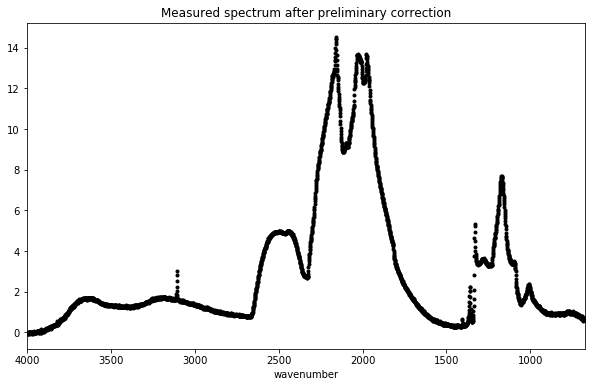

In [8]:
plt.figure()
plt.plot(spectrum[:,0], spectrum[:,1], 'k.')
plt.xlim(675,4000)
plt.xlabel('wavenumber')
plt.title('Measured spectrum after preliminary correction')
plt.gca().invert_xaxis()
plt.show()

This looks better already!


### 1.2) Final Baseline Correction
The next step is to get rid of the intrinsic diamond peaks between about 1500 and 2700 cm$^{-1}$ and remove any remaining slope from the spectrum. This is achieved by fitting the corrected spectrum to the standard type IIa spectrum with a least squares routine. In order to do this, we need to extract the two phonon region (i.e. the intrinsic diamond peaks) from the corrected spectrum. The region between 2313 and 2390 cm$^{-1}$ is exlcuded because it often contains remnants of insufficiently removed atmospheric CO$_2$. The wavenumber ranges below 1500 and 3000 to 3800 cm$^{-1}$ are not used because they contain other peaks, such es the ones related to nitrogen- and hydrogen-containing defects and platelets.

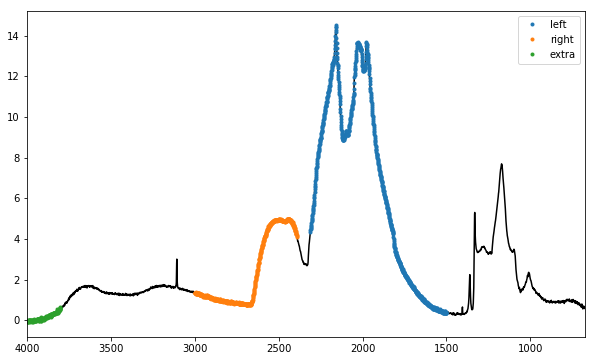

In [9]:
two_phonon_left = ut.spectrum_slice(spectrum, 1500,2312)
two_phonon_right = ut.spectrum_slice(spectrum, 2391, 3000)
two_phonon_extra = ut.spectrum_slice(spectrum, 3800, 4000)
#stacking the three spectral regions together for convenience:
two_phonon = np.vstack((two_phonon_left, two_phonon_right, two_phonon_extra))
two_phonon_wav = np.arange(two_phonon[:,0][0], two_phonon[:,0][-1], 0.1)

plt.figure()
plt.plot(spectrum[:,0], spectrum[:,1], 'k-')
plt.plot(two_phonon_left[:,0],two_phonon_left[:,1], '.', label='left')
plt.plot(two_phonon_right[:,0],two_phonon_right[:,1], '.', label='right')
plt.plot(two_phonon_extra[:,0],two_phonon_extra[:,1], '.', label='extra')
plt.xlim(675,4000)
plt.gca().invert_xaxis()
plt.legend(loc='best')
plt.show()

In [10]:
# the inter function interpolates spectral data using the new wavenumber values defined by two_phonon_wav:
two_phonon_ip = ut.inter(spectrum, two_phonon_wav, inttype='linear')          

IIa_spec_ip = ut.inter(IIa_spec, two_phonon_wav, inttype='linear') 
IIa_spec_ip_new = ut.inter(IIa_spec, spectrum[:,0:-1], inttype='linear')

# arguments needed for IIa_fit:
IIa_args = (two_phonon_wav, two_phonon_ip, IIa_spec_ip)
#initial guess of parameters (normf, poly1, poly2):
IIa_x0 = [(1, 0, 0)]
#bounds (min, max-pairs) for parameters:
IIa_bounds = [(0.0, None),(None, None),(None, None)]

#least squares minimisation using the function IIa, which returns the difference between our interpolated standard IIa spectrum (IIa_spec_ip)
#and the sum of a measured spectrum (two-phonon-ip) multiplied by a factor (normf) and a second order polynomial (y = poly1 + two_phonon_wav*poly2)
IIa_res = op.minimize(ut.IIa, args=IIa_args, x0=IIa_x0, method='L-BFGS-B', bounds=IIa_bounds)
print(IIa_res)

#the fit_IIa function returns the fitted spectrum using the parameters determined by least squares optimisation
fit_IIa = ut.IIa_fit(IIa_res.x, spectrum[:,0].reshape(len(spectrum[:,0]),1), spectrum[:,1].reshape(len(spectrum[:,1]),1)) 
abs_temp = fit_IIa - IIa_spec_ip_new

#stack old wavenumber values and new, corrected absorption values for convenience
spec_final = np.column_stack((spectrum[:,0] , abs_temp))

      fun: 107.66864676317115
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.23660412e-01,  -6.21872191e+02,  -3.30027206e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 148
      nit: 13
   status: 0
  success: True
        x: array([  9.93353256e-01,  -1.69855053e-05,  -4.33308521e-02])


Let's look at the resulting spectrum and make sure the fit is OK.

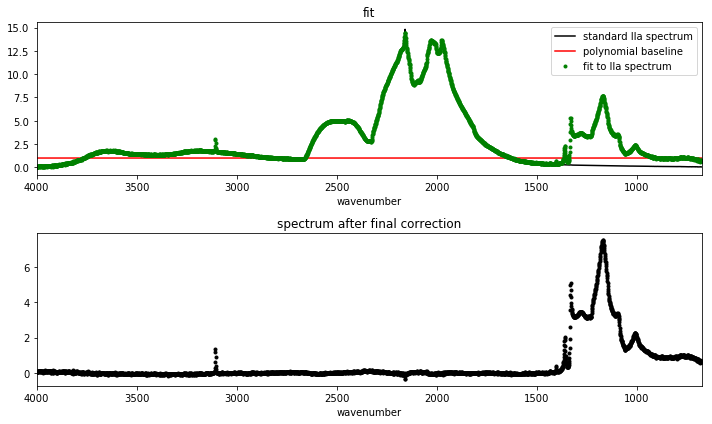

In [11]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(IIa_spec[:,0], IIa_spec[:,1], 'k-', label='standard IIa spectrum')
plt.plot(spectrum[:,0], np.polyval((IIa_res.x[:1]), spectrum[:,0]), 'r-', label='polynomial baseline')
plt.plot(spectrum[:,0], fit_IIa, 'g.', label='fit to IIa spectrum')
plt.xlim(675,4000)
plt.xlabel('wavenumber')
plt.title('fit')
plt.legend(loc='best')
plt.gca().invert_xaxis()

plt.subplot(2,1,2)
plt.plot(spec_final[:,0], spec_final[:,1], 'k.')
plt.xlim(675,4000)
plt.xlabel('wavenumber')
plt.title('spectrum after final correction')
plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()